In [79]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [80]:
#!pip install seaborn
!pip install scikit-learn

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import itertools
import sklearn

%matplotlib inline
from ucimlrepo import fetch_ucirepo


In [83]:
# data link 1 - https://archive.ics.uci.edu/dataset/20/census+income
# data link 2 - https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
# fetch dataset

adult = fetch_ucirepo(id=2)
census_income = fetch_ucirepo(id=20)

df_data = census_income.data.features
df_data['target'] = census_income.data.targets
df_data.loc[df_data["target"] == "<=50K", "target"] = 0
df_data.loc[df_data["target"] == "<=50K.", "target"] = 0
df_data.loc[df_data["target"] == ">50K", "target"] = 1
df_data.loc[df_data["target"] == ">50K.", "target"] = 1
df_data['target'] = df_data['target'].astype(int)
df_data = df_data.sample(n=2000)

## Check Data
1. Missing values
2. Duplicates
3. Data types of features
4. Unique values for each feature
5. Numerical and Categorical Features


(2000, 15)
(1945, 15)
Number of duplicate records 0
Number of duplicate records 0
<class 'pandas.core.frame.DataFrame'>
Index: 1945 entries, 16784 to 44960
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1945 non-null   int64 
 1   workclass       1945 non-null   object
 2   fnlwgt          1945 non-null   int64 
 3   education       1945 non-null   object
 4   education-num   1945 non-null   int64 
 5   marital-status  1945 non-null   object
 6   occupation      1945 non-null   object
 7   relationship    1945 non-null   object
 8   race            1945 non-null   object
 9   sex             1945 non-null   object
 10  capital-gain    1945 non-null   int64 
 11  capital-loss    1945 non-null   int64 
 12  hours-per-week  1945 non-null   int64 
 13  native-country  1945 non-null   object
 14  target          1945 non-null   int64 
dtypes: int64(7), object(8)
memory usage: 243.1+ KB
 Have 7 Num

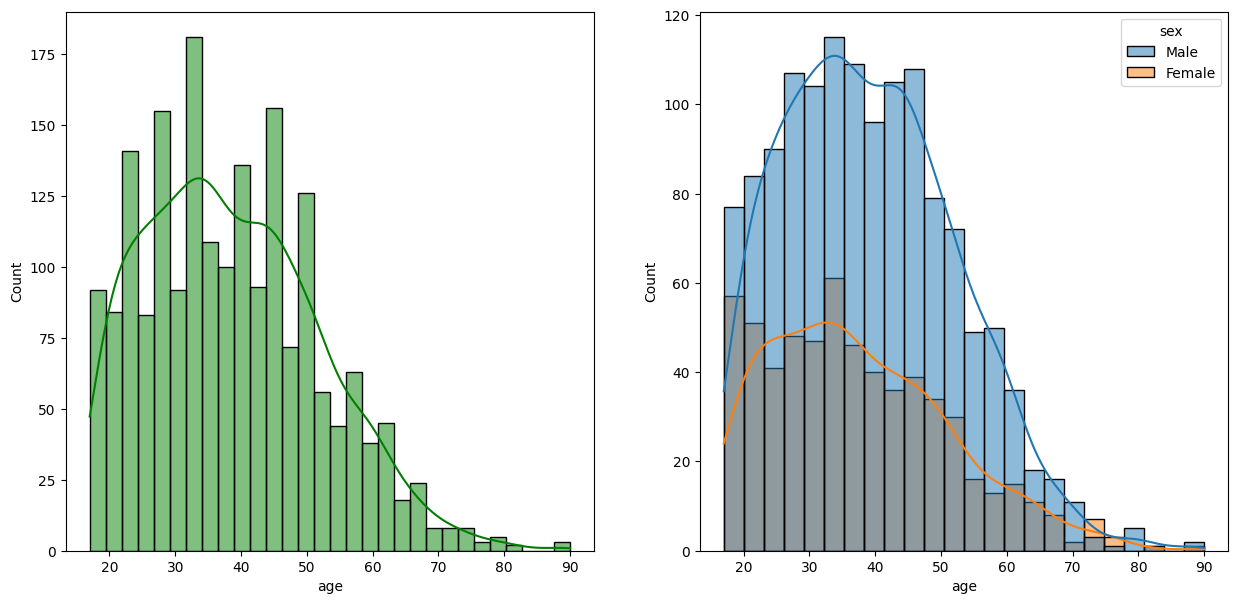

In [84]:
# 1. Missing values
df_data.isna().sum()
print(df_data.shape)
df_data.dropna(inplace=True)
print(df_data.shape)

#2 Duplicates
df_data.duplicated().sum()
print(f"Number of duplicate records {df_data.duplicated().sum()}")
df_data.drop_duplicates(inplace=True)
print(f"Number of duplicate records {df_data.duplicated().sum()}")

# Data type
df_data.info()

# Unique values of each column
df_data.nunique()

#5. Numerical and Categorical Features

numerical_features = [feature for feature in  df_data.columns if df_data[feature].dtype != 'O']
categorical_features = [feature for feature in  df_data.columns if df_data[feature].dtype == 'O']
print(" Have {} Numerical Features {} ".format(len(numerical_features),numerical_features))
print(" Have {} Categorical Features {} ".format(len(categorical_features),categorical_features))

# Data Statistics 
df_data.describe()

# Explore Data
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df_data,x='age',bins=30,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df_data,x='age',kde=True,hue='sex')
plt.show()

In [85]:
df_data['native-country'].unique()

array(['United-States', 'Puerto-Rico', 'Cuba', 'Philippines', '?',
       'South', 'El-Salvador', 'India', 'Jamaica', 'Mexico', 'Germany',
       'England', 'Outlying-US(Guam-USVI-etc)', 'Taiwan', 'Ecuador',
       'Poland', 'Portugal', 'Trinadad&Tobago', 'Peru', 'Columbia',
       'Canada', 'Dominican-Republic', 'China', 'Laos', 'Haiti', 'Italy',
       'Thailand', 'Guatemala', 'Cambodia', 'Honduras', 'Iran', 'Greece',
       'Japan', 'Vietnam'], dtype=object)

In [86]:
# Explore Data
pd.set_option('display.max_rows', 500)

by_sex = df_data.groupby(['sex'])[['sex']].count()
print(by_sex)
by_sex_t = df_data.groupby(['sex','target'])[['target']].count()
#by_age = df_data.groupby(['age','target'])[['target']].count()
by_race = df_data.groupby(['race','target'])[['target']].count()
by_native_country = df_data.groupby(['native-country','target'])[['target']].count()
#print(by_sex_t)
#print(by_age)
#print(by_race)
#print(by_native_country)

df_data.groupby(['occupation'])[['target']].count()

         sex
sex         
Female   607
Male    1338


,target
occupation,
?,88
Adm-clerical,205
Craft-repair,231
Exec-managerial,286
Farming-fishing,49
Handlers-cleaners,88
Machine-op-inspct,113
Other-service,215
Priv-house-serv,13


## Data Transformation

In [87]:

X = df_data.drop(['target'],axis=1)
y= df_data['target']

print(y)
num_features= X.select_dtypes(exclude="object").columns
cat_features= X.select_dtypes(include="object").columns
num_pipeline = Pipeline(
   steps=[
       ("Imputer",SimpleImputer(strategy="median")),
       ("Scaler", StandardScaler())
   ]
)
cat_pipeline= Pipeline(
    steps=[
      ("Imputer",SimpleImputer(strategy="most_frequent")),
      ("one_hot_encoder",OneHotEncoder()),
      ("scaler",StandardScaler(with_mean=False))
    ]
)
preprocessor = ColumnTransformer(
    [
      ("num_pipeline",num_pipeline, num_features) ,
      ("cat_pipeline",cat_pipeline, cat_features)

    ]
)

X= preprocessor.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
train_time={}
classifier_accuracy={}
predict_time ={}

16784    0
44586    1
6700     0
14164    0
2842     0
        ..
43915    0
21649    1
47199    0
37937    0
44960    0
Name: target, Length: 1945, dtype: int64


In [88]:
def plot_validation_curve(classifier, classifier_name, X_train, y_train,param_range,param_code,param_name,cv,is_log,x_tick):

    train_scores, test_scores = validation_curve(classifier, X_train, y_train, param_range=param_range,param_name=param_code,cv=cv)
    plt.figure()
    if is_log:
        plt.semilogx(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.semilogx(param_range, np.mean(test_scores, axis=1), label='CV Score')
    else:
        plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.plot(param_range, np.mean(test_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title("Validation Curve for "+param_name+" "+classifier_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if x_tick.any():
        plt.xticks(param_range)
    plt.grid()
    plt.savefig(classifier_name+'_'+param_code+'validation_curve.png')
    plt.show()

In [89]:
def plot_matrix(cm, classifier_name,normalize=False,cmap=plt.cm.Greys):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix '+ 'for '+ classifier_name)
    plt.colorbar()
    tick_marks = np.arange(len(["0","1"]))
    plt.xticks(tick_marks, ["0","1"])
    plt.yticks(tick_marks, ["0","1"])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    

In [90]:
def get_best_params(classifier,classifier_name,X_test,y_test,param_grid,cv):
    # Grid Search
    #param_grid = {'n_neighbors': np.arange(1,100), 'p':np.arange(1,6)}
    classifier_best = GridSearchCV(classifier, param_grid=param_grid, cv=cv)

    start_time = time.time()
    classifier_best.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time-start_time
   
    print(f"Best params for {classifier_name} : {classifier_best.best_params_}")

    start_time = time.time()
    y_predict =  classifier_best.predict(X_test)
    end_time = time.time()
    pred_time =  end_time-start_time
    
    accuracy = accuracy_score(y_test,y_predict)
    auc = roc_auc_score(y_test, y_predict)
    f1 = f1_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    matrix = confusion_matrix(y_test,y_predict)
    
   
    print(f"{classifier_name} Evaluation Metrics ")
    print("-----------------------------------------------------")
    print("Training Time (s):   "+"{:.5f}".format(training_time))
    print("Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("Accuracy:  "+"{:.5f}".format(accuracy))
    print("AUC:       "+"{:.5f}".format(auc))
    print("F1 Score:  "+"{:.5f}".format(f1))
    print("Precision: "+"{:.5f}".format(precision))
    print("Recall:    "+"{:.5f}".format(recall))
    
    print("-----------------------------------------------------")
    plt.figure()
    plot_matrix(matrix,classifier_name)
    plt.show()
    train_time[classifier_name]= training_time
    predict_time[classifier_name] = pred_time
    classifier_accuracy[classifier_name]=accuracy
    
   
    return classifier_best

In [91]:
def plot_learning_curve(classifier,classifier_name, X_train, y_train, train_sizes, cv, series,x_tick):
    _, train_scores, test_scores = learning_curve(classifier, X_train, y_train, train_sizes=train_sizes, cv=cv)

    plt.figure()
    plt.plot(series, np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(series, np.mean(test_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title("Learning Curve for "+ classifier_name)
    plt.xlabel("Percentage of Training Examples")
    plt.ylabel("Score")
    if x_tick.any():
        plt.xticks(x_tick)
    plt.grid()
    plt.savefig(classifier_name+'learning_curve.png')
    plt.show()


In [92]:
# x= time, y= classifiers

def plot_time_graph(x_series,y_series,title,x_label):
    y_ticks= np.arange(len(y_series))
    plt.figure()
    plt.barh(y_ticks, x_series)
    plt.gca().set_yticks(y_ticks)
    plt.gca().set_yticklabels(y_series)
    plt.title(title)
    plt.xlabel(x_label)
    #plt.savefig('bc_training.png', dpi=300, bbox_inches='tight')
    plt.show()

## Decision Tree

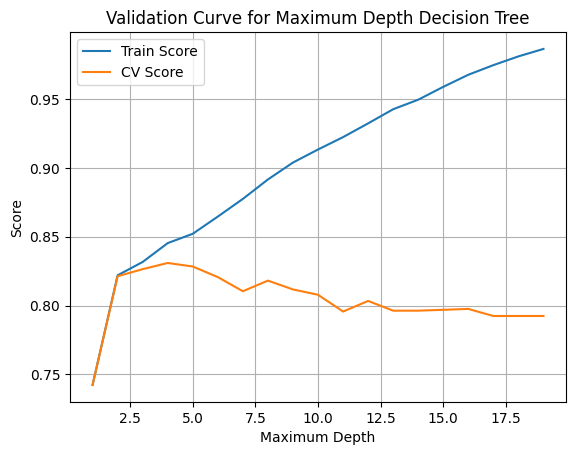

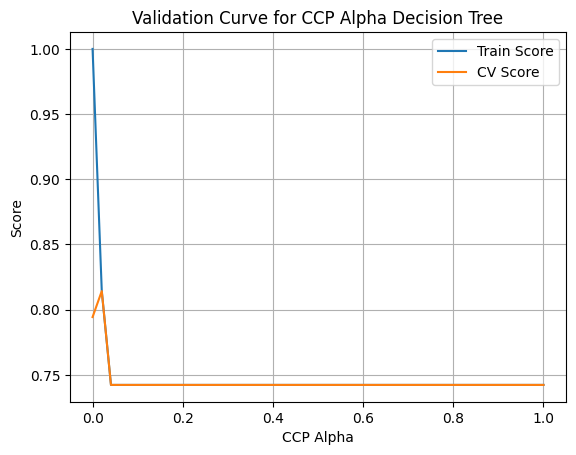

Best params for Decision Tree : {'ccp_alpha': 0.0, 'max_depth': 5}
Decision Tree Evaluation Metrics 
-----------------------------------------------------
Training Time (s):   4.24046
Prediction Time (s): 0.00022

Accuracy:  0.83290
AUC:       0.79576
F1 Score:  0.68293
Precision: 0.64815
Recall:    0.72165
-----------------------------------------------------


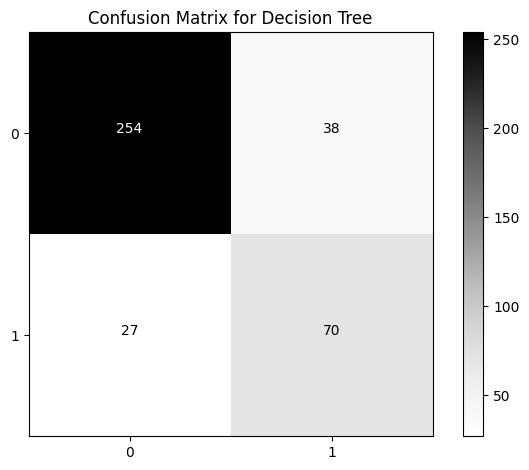

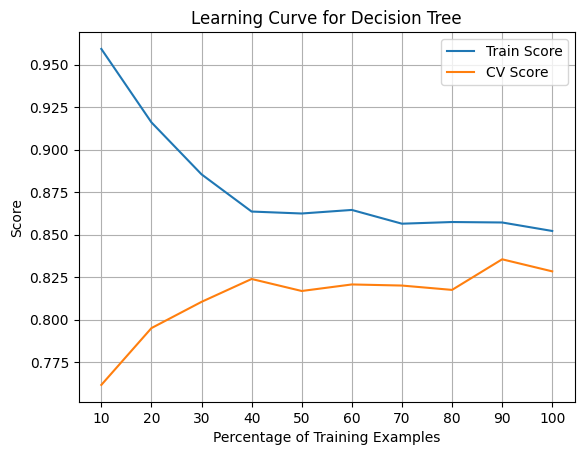

In [95]:
classifier_name = 'Decision Tree'
classifier_decision_tree = DecisionTreeClassifier(random_state=42)
cv = 10
plot_validation_curve(classifier=classifier_decision_tree,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.arange(1,20), param_code='max_depth',param_name='Maximum Depth', cv=cv,is_log=False,x_tick=np.arange(0,0))
plot_validation_curve(classifier=classifier_decision_tree,classifier_name='Decision Tree', X_train=X_train, y_train=y_train,param_range=np.linspace(0,1,50), param_code='ccp_alpha',param_name='CCP Alpha', cv=cv,is_log=False,x_tick=np.arange(0,0))

param_grid = {'max_depth': np.arange(1,20), 'ccp_alpha': np.linspace(0,0.035,10)}
classifier_decision_tree_best=get_best_params(classifier=classifier_decision_tree,classifier_name=classifier_name,X_test=X_test,y_test=y_test,param_grid=param_grid,cv=4)

classifier_decision_tree_learning = DecisionTreeClassifier(random_state=42, max_depth=classifier_decision_tree_best.best_params_['max_depth'], ccp_alpha=classifier_decision_tree_best.best_params_['ccp_alpha'])

plot_learning_curve(classifier=classifier_decision_tree_learning,classifier_name=classifier_name, X_train=X_train, y_train=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=cv,series=np.linspace(0.1,1.0,10)*100,x_tick=np.linspace(0.1,1.0,10)*100)


## KNN

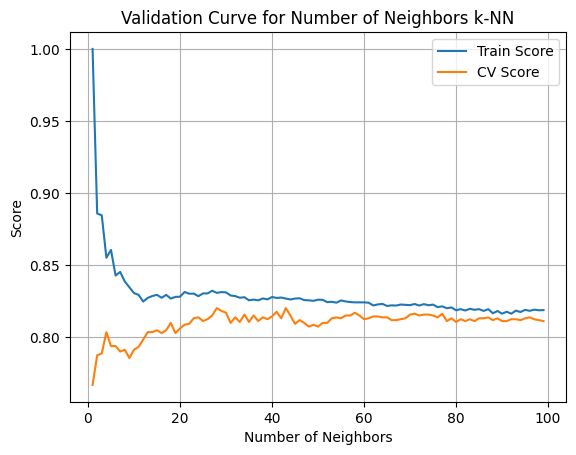

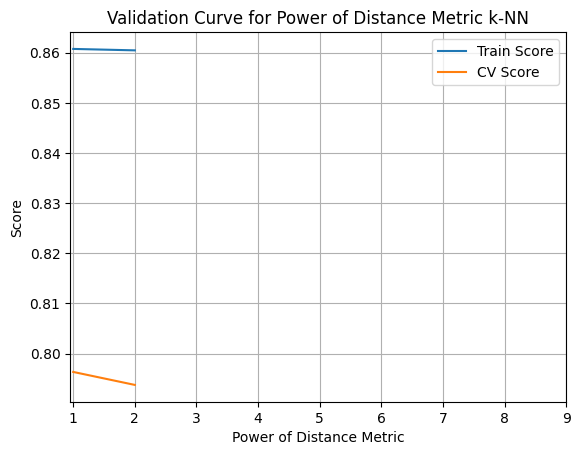

Best params for k-NN : {'n_neighbors': 28, 'p': 2}
k-NN Evaluation Metrics 
-----------------------------------------------------
Training Time (s):   23.73002
Prediction Time (s): 0.02101

Accuracy:  0.82005
AUC:       0.72179
F1 Score:  0.59302
Precision: 0.68000
Recall:    0.52577
-----------------------------------------------------


/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
2970 fits failed out of a total of 4950.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2970 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/manish.upadhyay/miniconda3/lib/python3

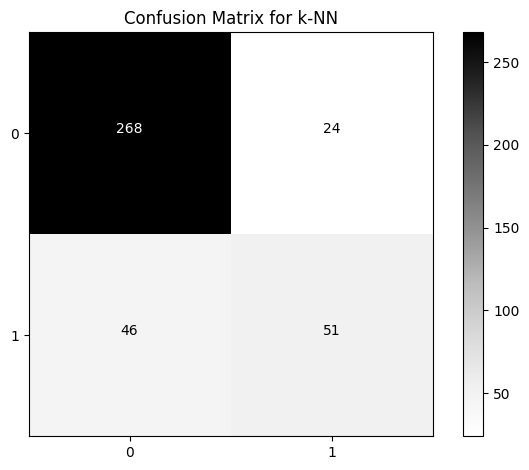

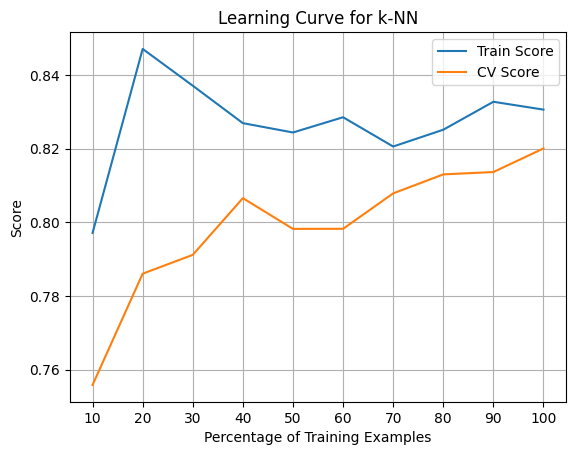

In [96]:
classifier_knn = KNeighborsClassifier()
classifier_name= 'k-NN'
cv = 10
plot_validation_curve(classifier=classifier_knn,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.arange(1,100), param_code='n_neighbors',param_name='Number of Neighbors', cv=cv,is_log=False,x_tick=np.arange(0,0))
plot_validation_curve(classifier=classifier_knn,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.arange(1,10), param_code='p',param_name='Power of Distance Metric', cv=cv,is_log=False,x_tick=np.arange(1,10))
param_grid = {'n_neighbors': np.arange(1,100), 'p':np.arange(1,6)}
classifier_knn_best=get_best_params(classifier=classifier_knn,classifier_name=classifier_name,X_test=X_test,y_test=y_test,param_grid=param_grid,cv=cv)
classifier_knn_learning = KNeighborsClassifier(n_neighbors=classifier_knn_best.best_params_['n_neighbors'], p=classifier_knn_best.best_params_['p'])

plot_learning_curve(classifier_knn_learning,classifier_name,X_train,y_train,train_sizes=np.linspace(0.1,1.0,10),cv=cv,series=np.linspace(0.1,1.0,10)*100,x_tick=np.linspace(0.1,1.0,10)*100)


## SVM

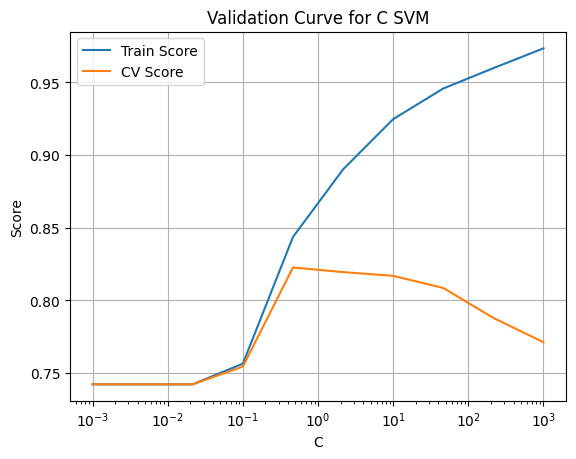

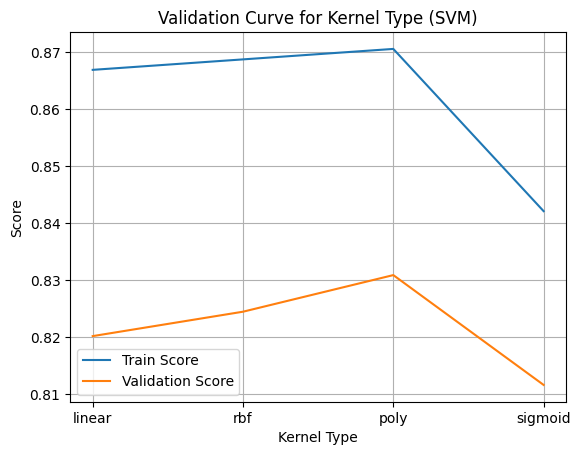

Best params for SVM : {'C': 10.0, 'kernel': 'linear'}
SVM Evaluation Metrics 
-----------------------------------------------------
Training Time (s):   659.14792
Prediction Time (s): 0.00620

Accuracy:  0.84576
AUC:       0.79399
F1 Score:  0.69072
Precision: 0.69072
Recall:    0.69072
-----------------------------------------------------


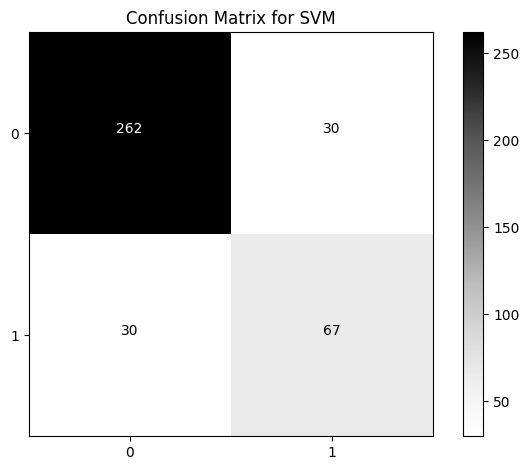

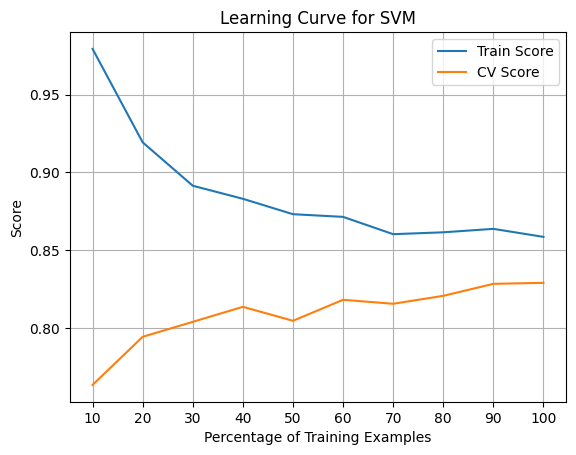

In [97]:
classifier_name= 'SVM'
cv = 10
classifier_svm = svm.SVC(random_state=42)
plot_validation_curve(classifier=classifier_svm,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.logspace(-3,3,10), param_code='C',param_name='C', cv=cv,is_log=True,x_tick=np.arange(0,0))

train_scores = np.zeros((4,1))
test_scores = np.zeros((4,1))

classifier_svm = svm.SVC(random_state=42, kernel='linear')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[0] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[0] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='rbf')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[1] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[1] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='poly')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[2] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[2] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='sigmoid')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[3] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[3] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

plt.figure()
plt.plot(np.arange(0,4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0,4), np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4),['linear','rbf','poly','sigmoid'])
plt.show()

param_grid = {'C': np.logspace(-3,3,10), 'kernel': ['linear','rbf','poly','sigmoid']}
classifier_svm_best=get_best_params(classifier=classifier_svm,classifier_name=classifier_name,X_test=X_test,y_test=y_test,param_grid=param_grid,cv=cv)

classifier_svm_learning = svm.SVC(random_state=42, C=classifier_svm_best.best_params_['C'], kernel=classifier_svm_best.best_params_['kernel'])
plot_learning_curve(classifier_svm_learning,classifier_name,X_train,y_train,train_sizes=np.linspace(0.1,1.0,10),cv=cv,series=np.linspace(0.1,1.0,10)*100,x_tick=np.linspace(0.1,1.0,10)*100)


##  ANN

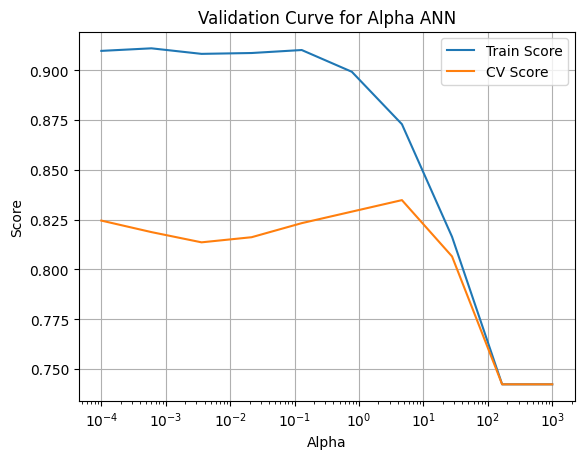

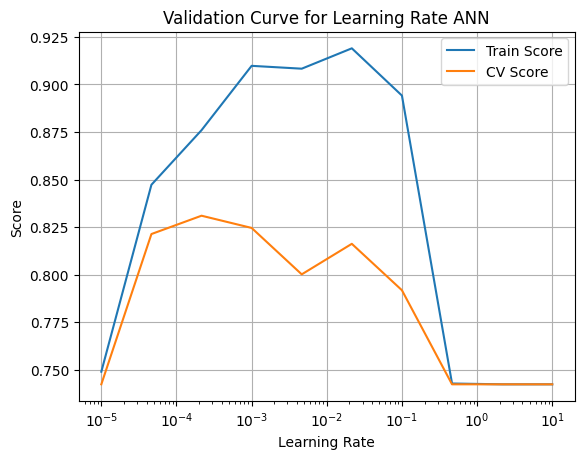

/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manish.upadhyay/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  war

Best params for ANN : {'alpha': 2.154434690031882, 'learning_rate_init': 0.00021544346900318823}
ANN Evaluation Metrics 
-----------------------------------------------------
Training Time (s):   152.21538
Prediction Time (s): 0.00019

Accuracy:  0.85604
AUC:       0.80772
F1 Score:  0.71134
Precision: 0.71134
Recall:    0.71134
-----------------------------------------------------


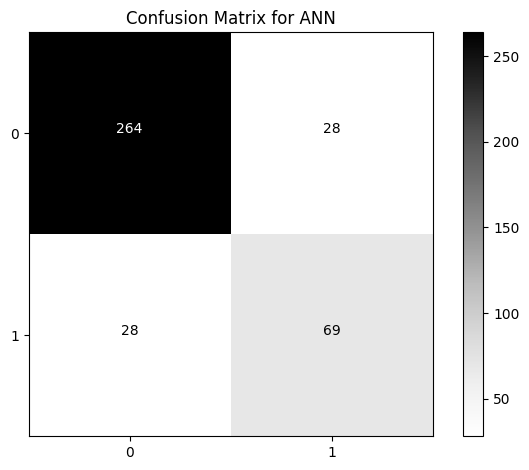

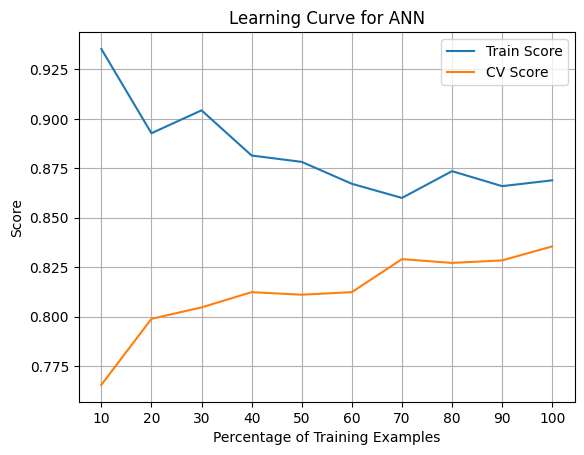

In [98]:
classifier_ann = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000)
plot_validation_curve(classifier=classifier_ann,classifier_name='ANN', X_train=X_train, y_train=y_train,param_range=np.logspace(-4,3,10), param_code='alpha',param_name='Alpha', cv=4,is_log=True,x_tick=np.arange(0,0))
plot_validation_curve(classifier=classifier_ann,classifier_name='ANN', X_train=X_train, y_train=y_train,param_range=np.logspace(-5,1,10), param_code='learning_rate_init',param_name='Learning Rate', cv=4,is_log=True,x_tick=np.arange(0,0))
param_grid = {'alpha': np.logspace(-3,3,10), 'learning_rate_init': np.logspace(-5,1,10)}
classifier_ann_best = get_best_params(classifier=classifier_ann,classifier_name="ANN",X_test=X_test,y_test=y_test,param_grid=param_grid,cv=4)

classifier_ann_learning = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000, learning_rate_init=classifier_ann_best.best_params_['learning_rate_init'], alpha=classifier_ann_best.best_params_['alpha'])
plot_learning_curve(classifier_ann_learning,"ANN",X_train,y_train,train_sizes=np.linspace(0.1,1.0,10),cv=4,series=np.linspace(0.1,1.0,10)*100,x_tick=np.linspace(0.1,1.0,10)*100)


## Boosting

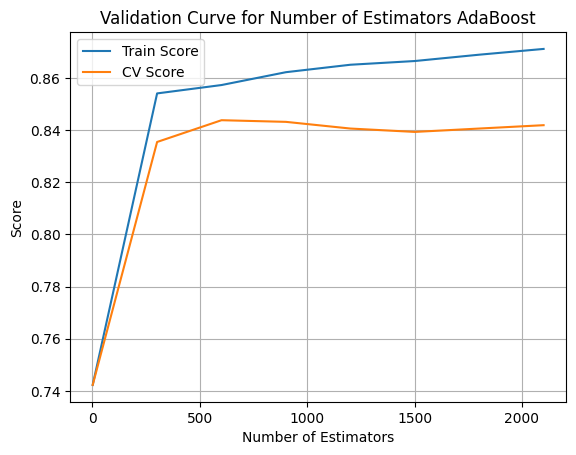

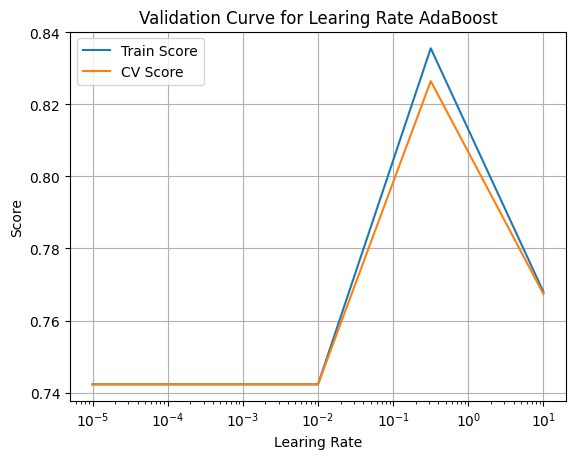

Best params for AdaBoost : {'learning_rate': 0.31622776601683794, 'n_estimators': 1501}
AdaBoost Evaluation Metrics 
-----------------------------------------------------
Training Time (s):   153.04537
Prediction Time (s): 0.08269

Accuracy:  0.87147
AUC:       0.79046
F1 Score:  0.70930
Precision: 0.81333
Recall:    0.62887
-----------------------------------------------------


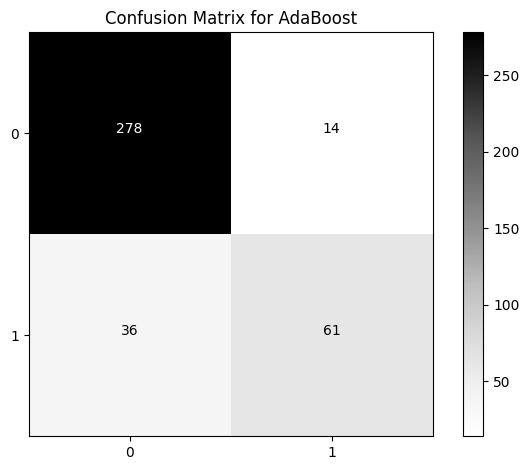

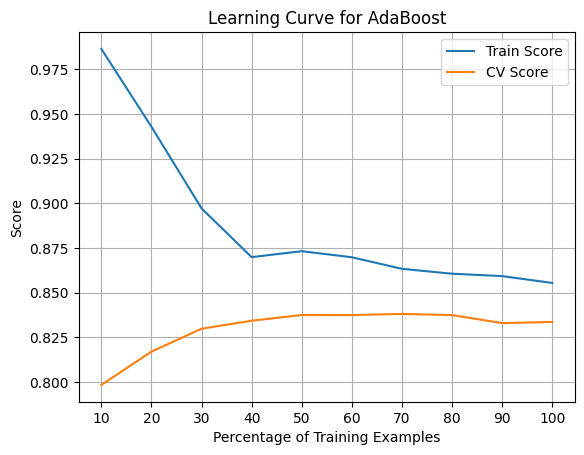

In [99]:
classifier_name='AdaBoost'
cv =10
classifier_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, min_samples_leaf=1),algorithm='SAMME', random_state=42)
plot_validation_curve(classifier=classifier_adaboost,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.arange(1,2102,300), param_code='n_estimators',param_name='Number of Estimators', cv=cv,is_log=False,x_tick=np.arange(0,0))
plot_validation_curve(classifier=classifier_adaboost,classifier_name=classifier_name, X_train=X_train, y_train=y_train,param_range=np.logspace(-5,1,5), param_code='learning_rate',param_name='Learing Rate', cv=cv,is_log=True,x_tick=np.arange(0,0))
param_grid = {'learning_rate': np.logspace(-5,1,5), 'n_estimators': np.arange(1,2102,300)}
classifier_adaboost_best = get_best_params(classifier=classifier_adaboost,classifier_name=classifier_name,X_test=X_test,y_test=y_test,param_grid=param_grid,cv=4)

classifier_adaboost_learning = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, min_samples_leaf=1),algorithm='SAMME', random_state=42, n_estimators=classifier_adaboost_best.best_params_['n_estimators'], learning_rate=classifier_adaboost_best.best_params_['learning_rate'])
plot_learning_curve(classifier_adaboost_learning,"AdaBoost",X_train,y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,series=np.linspace(0.1,1.0,10)*100,x_tick=np.linspace(0.1,1.0,10)*100)



In [100]:
train_time

{'Decision Tree': 4.240463018417358,
 'k-NN': 23.73002004623413,
 'SVM': 659.147919178009,
 'ANN': 152.2153820991516,
 'AdaBoost': 153.0453701019287}

In [101]:
classifier_accuracy


{'Decision Tree': 0.8329048843187661,
 'k-NN': 0.8200514138817481,
 'SVM': 0.8457583547557841,
 'ANN': 0.8560411311053985,
 'AdaBoost': 0.87146529562982}

In [102]:
predict_time

{'Decision Tree': 0.00022077560424804688,
 'k-NN': 0.02100992202758789,
 'SVM': 0.006203889846801758,
 'ANN': 0.00019097328186035156,
 'AdaBoost': 0.08269000053405762}

{'Decision Tree': 4.240463018417358, 'k-NN': 23.73002004623413, 'SVM': 659.147919178009, 'ANN': 152.2153820991516, 'AdaBoost': 153.0453701019287}


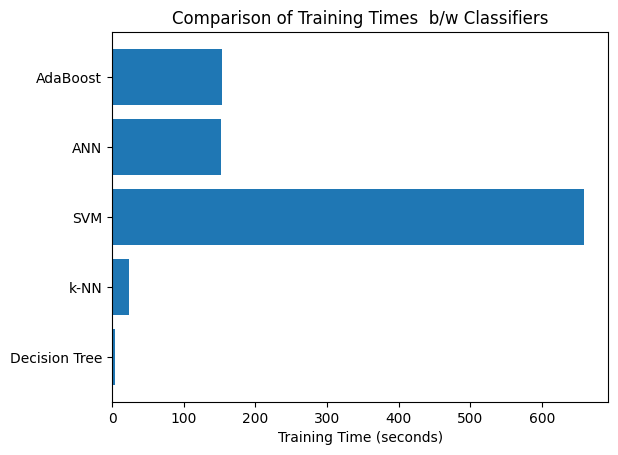

{'Decision Tree': 0.8329048843187661, 'k-NN': 0.8200514138817481, 'SVM': 0.8457583547557841, 'ANN': 0.8560411311053985, 'AdaBoost': 0.87146529562982}


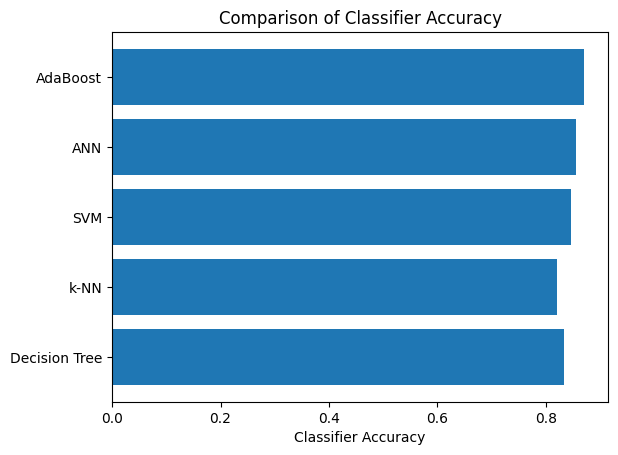

{'Decision Tree': 0.00022077560424804688, 'k-NN': 0.02100992202758789, 'SVM': 0.006203889846801758, 'ANN': 0.00019097328186035156, 'AdaBoost': 0.08269000053405762}


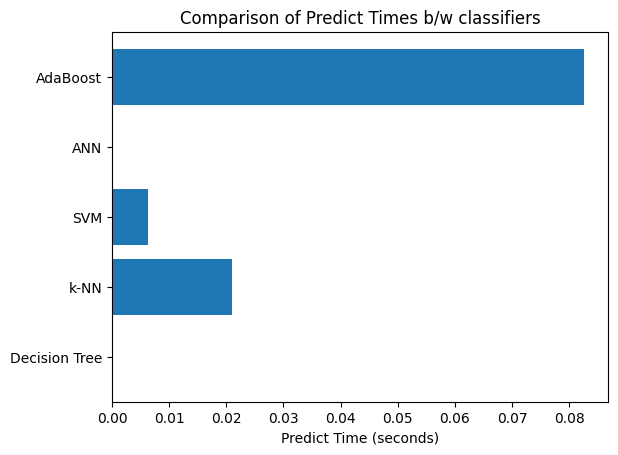

In [103]:
# Plot training time comparision between classifiers
x_series=list(train_time.values())
y_series = list(train_time.keys())
print(train_time)
plot_time_graph(x_series,y_series,'Comparison of Training Times  b/w Classifiers','Training Time (seconds)')
# plot classifier accuracy\
print(classifier_accuracy)
x_series=list(classifier_accuracy.values())
y_series = list(classifier_accuracy.keys())
plot_time_graph(x_series,y_series,'Comparison of Classifier Accuracy','Classifier Accuracy')
# plot predict time comparision between classifiers
print(predict_time)
x_series=list(predict_time.values())
y_series = list(predict_time.keys())
plot_time_graph(x_series,y_series,'Comparison of Predict Times b/w classifiers','Predict Time (seconds)')
